In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from time import time
import xlrd
from matplotlib import offsetbox
from sklearn import manifold, decomposition
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [7]:
pd.options.display.float_format = '{:.2f}'.format
f = pd.read_excel("./Задача.xlsx")
f = f[f.columns[1:]]
f.columns = ["age, years", "driving experience, years", "losses, %", "wage level, rub/year"]
print f.shape
f.describe()

(484, 4)


,"age, years","driving experience, years","losses, %","wage level, rub/year"
count,484.00,484.00,484.00,484.00
mean,45.32,21.42,227.07,1017900.84
std,19.63,18.04,171.56,1187545.13
min,20.00,1.00,20.00,120185.00
25%,26.00,5.00,103.00,194998.00
50%,39.50,15.00,173.00,441028.00
75%,65.00,38.00,299.25,1109668.25
max,79.00,58.00,700.00,3982828.00


Как видно, величины в данных совершенно несоразмерны. Приведем их к виду, когда среднее значение по признаку равно 1. Как правило, на таких данных оптимизация быстрее сходится.

In [8]:
data = f.apply(lambda x: 1.0*x / np.mean(x))

Здесь для удобства я выношу функцию, которая строит мне графики

In [9]:
colors = ["bo", "go", "ro", "co", "mo"]
def plot_function(X, y = None, time = 0, name = "", method = ""):
    if(y != None):
        plt.figure(figsize = (12, 3))
        ax = plt.subplot(111)
        for i,t in enumerate(X):
            plt.plot(t[0], t[1], colors[y[i]])
        plt.title(name + ", " + method)
    else:
        plt.figure(figsize = (12,3))
        for t in X:
            plt.plot(t[0], t[1], "ro")
        plt.title(method + " embedding, computational time = %.2f sec"%time)
    plt.show()

Признаков в данных всего 4, это значит, что если данные как-то кластеризованы по своей структуре, то это скорее всего будет видно, если сделать отображение данных в двумерное пространство определенным образом и нарисовать картинку. На мой взгляд, это лучший способ посмотреть на данные в этой задаче, чтобы понять, что дальше делать и на какой уровень качества можно претендовать.

То есть каждый точка - это точка исходной выборки, но ее координаты преобразованы в двумерное пространство. В случае t-SNE это преобразование можно кратко охаректеризовать принципом "близкие точки сближаются, далекие отдаляются", это сложное нелинейное преобразование, которое, как видно, считается довольно долго. В случае метода главных компонент это просто проекция точек на плоскость, задающуюся векторами, в направлении которых максимизируется дисперсия выборки (поэтому кластеры вытянутые).

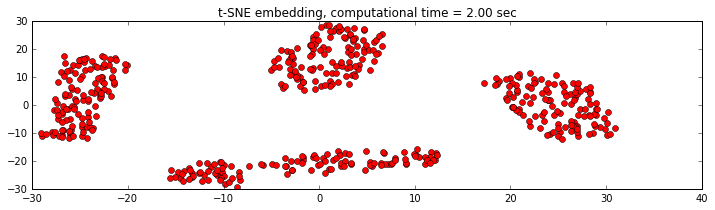

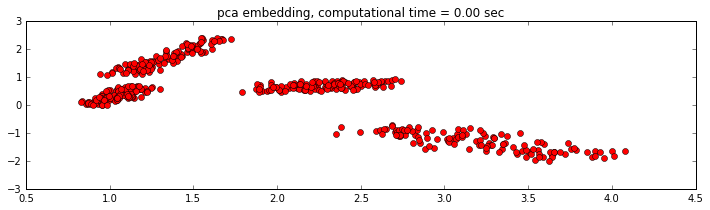

In [10]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(data)
plot_function(X = X_tsne, time = time() - t0, method = "t-SNE")

t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(data)
plot_function(X = X_pca, time = time() - t0, method = "pca")



Как видно, хорошо прослеживаются 4 отдельных кластера. Конечно, какая-то часть информации потерялась при отображении 4х - мерного пространства на 2-мерное. Например, нижний кластер, возможно, представляет из себя два. Применим кластеризацию из коробки, сделаем два принципиально разных алгоритма, чтобы удебиться, что итоговый результат устойчив и совпадает с нашим представлением по картинке выше.

После кластеризации я рисую каждый из полученных кластеров своим цветом. Можно также заметить, как скорее всего ошибся первый алгоритм, отнеся точку из синего кластера в голубой. В остальном результат получился вполне ожидаемым.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


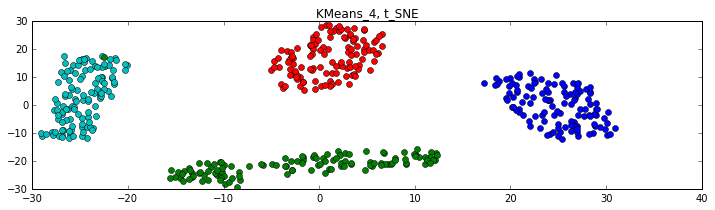

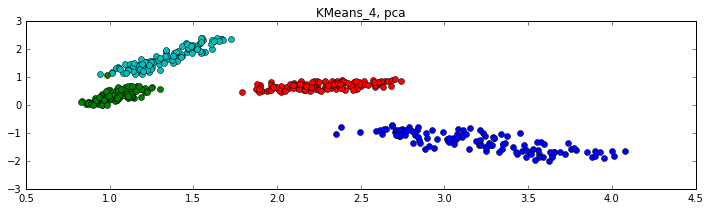

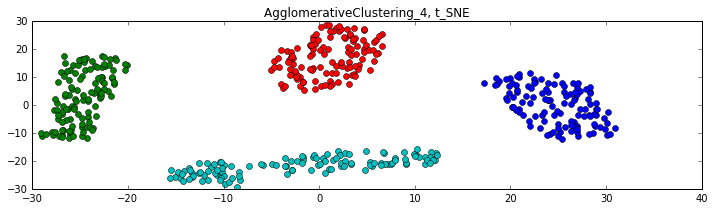

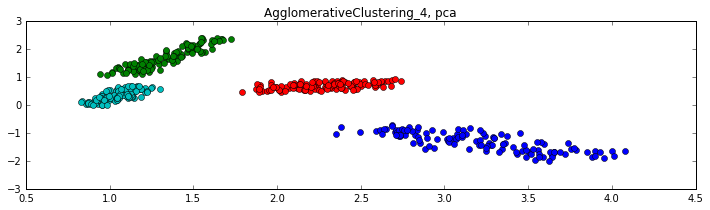

In [11]:
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.cluster import KMeans
clusterings = [KMeans(n_clusters = 4), AgglomerativeClustering(n_clusters = 4)]
names = ["KMeans_4", "AgglomerativeClustering_4"]

for i,algo in enumerate(clusterings):
    cur_labels = algo.fit(data).labels_
    plot_function(X = X_tsne, y = cur_labels, name = names[i], method = "t_SNE")
    plot_function(X = X_pca, y = cur_labels, name = names[i], method = "pca")
    print "====================================="
    

Дальше мы считаем центры кластеров и строим гисторгаммы значений по каждому отдельному признаку, чтобы была возможность посмотреть на исходные данные.

In [12]:
trained = AgglomerativeClustering(n_clusters=4).fit(data)
f["labels"] = trained.labels_
values = [f[f["labels"] == i].mean() for i in xrange(4)]
centers = pd.DataFrame(data = values, columns=f.columns)
centers["labels"] = centers["labels"].astype(int64)
centers.sort_values(by = centers.columns[0])

,"age, years","driving experience, years","losses, %","wage level, rub/year",labels
3,24.50,2.59,203.02,700447.28,3
1,30.11,7.32,487.14,149461.62,1
0,56.82,29.93,65.75,2978736.00,0
2,69.85,45.83,152.38,242958.45,2


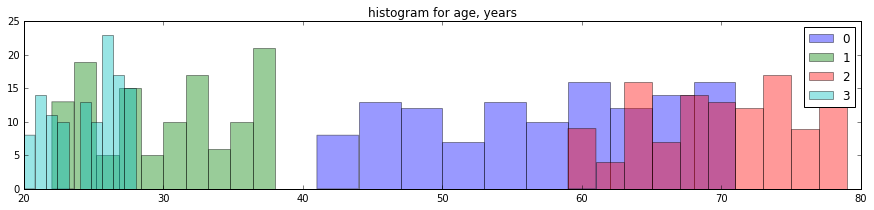

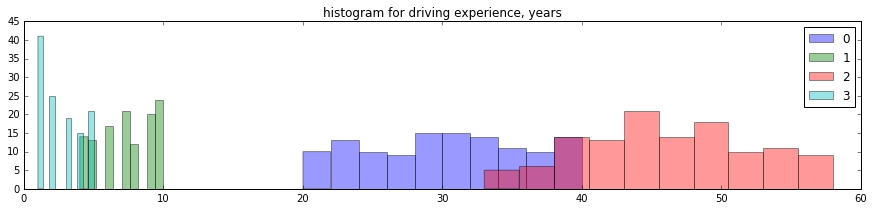

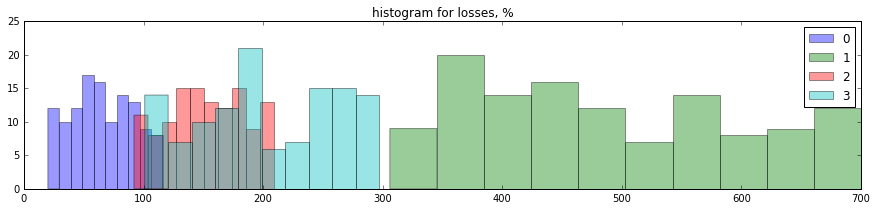

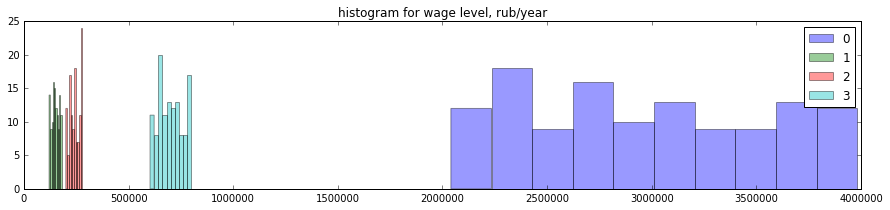

In [13]:
for col in xrange(4):
    plt.figure(figsize = (15,3))
    for label in xrange(4):
        plt.hist(f[f["labels"] == label][f.columns[col]], alpha = 0.4 , color = colors[label][0], label = str(label))
    plt.title("histogram for "+f.columns[col])
    plt.legend()
    plt.show()

Таким образом полученные кластеры можно описать так:
Кластер 0: Это зрелые люди с хорошим уровнем дохода, у них большой стаж, убытки в этой группе минимальны. Я бы назвал этот сегмент "Премиум".
Кластер 1: Это люди в возрасте 23-37 лет, у них небольшой доход, есть некоторый стаж вождения и издержки на них максимальны. Я бы сказал, что это люди, которые убедились в своем умении водить и поэтому не всегда осторожны. У них очень маленькая (серая) зарплата. Я бы назвал этот сегмент "ушлые".
Кластер 2: Это зрелые люди с небольшой зарплатой (пенсией) и большим стажем. Это пенсионеры со свойственной им осторожностью.
Кластер 3: Это молодые люди с небольшим опытом вождения и серьезными убытками для компании. Это студенты или недавние выпускники.